<a href="https://colab.research.google.com/github/casangi/examples/blob/master/community/Example_Wideband_PrimaryBeamCorrection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wideband Primary Beam Correction ( >= CASA 6.6.4 )

Original Author(s): rurvashi@nrao.edu

## Description 

Frequency dependent primary beams introduce artificial spectral structure into wide-field and mosaic images from instruments such as the VLA where broad-band data are combined to form images. This notebook contains examples of multiple ways to correct for this instrumental spectral index.

**Algorithm Options**

- [**Cube imaging with per-channel PB correction**](#Cube-Imaging-(specmode='cube'))
     - Each image channel is reconstructed independently and divided by a channel-dependent PB model. Examples include the 'standard' and 'mosaic' gridders.
- **Continuum (multi-term) imaging with wideband PB correction**
     - [**Option 1**](#Continuum-Imaging-Option-1-(specmode='mvc')) : Multi-term minor cycles are combined with cube major cycles, with frequency-dependent primary beam correction applied prior to deconvolution. The output spectral index image represents only the sky spectrum and needs no further correction. Examples in this notebook include the 'standard' and 'mosaic' gridders.
     - [**Option 2**](#Continuum-Imaging-Option-2-(specmode='mfs')) : Multi-term imaging that includes the sky and PB spectrum in the sky model, followed by a wideband pb-correction step after deconvolution. An example is provided only for the 'standard' gridder.

The 'standard' gridder examples apply as is to the 'wproject' gridder as well, since neither use primary beam models internally. Further examples with the 'awproject' (or equivalent) gridders will be added with a subsequent release.

[**An example VLA dataset**](#An-example-VLA-MS)

VLA L-Band (1-2 GHz) with 2 pointings, 3 channels at 1.2, 1.5, 1.8 GHz and one point source of intensity 1 Jy and alpha = -0.5 in-between the two pointings. Data were simulated one channel at a time using gridder='mosaic' and a true-sky model image cube (normtype='flatsky' to apply the appropriate PB during visibility prediction). This dataset is used within CASA's current verification test suite.

Truth values to compare the tclean outputs:

- The flat-sky (pb-corrected) intensity should be 1.0 Jy, with a sky spectral index of -0.5.

- At the location of the source, for the first field (field_id=0), the primary beam gain is approximately 0.5 with an instrumental spectral index of approximately -1.5.

- Derived quantities (for debugging, for field_id=0) : Wideband imaging without wideband PB correction (i.e. a flat noise image or sky model) will yield a spectral index of sky + PB = -0.5 - 1.5 = -2.0. For the 'mosaic' gridder, a PB weight image represents PB-square and will show a spectral index of 2 x -1.5 = -3.0.  

[**Using Custom Primary Beams**](#Imaging-With-Custom-Primary-Beams)

For use with custom primary beam models that are not already encoded within CASA (e.g. Upgraded GMRT), examples are also provided to show how to use **custom user-specified primary beam models** with specmode='mvc' to achieve wide-band primary beam correction without the need for a separate call to task_widebandpbcor.


### Installation

In [ ]:
import os

print("installing casa...")
os.system('pip install casaconfig')
os.system('pip install casatools==6.6.4.34')
os.system('pip install casatasks==6.6.4.34')
print("complete")

In [ ]:
print("configuring casa...")
## For google colab
mydatapath = '/content/.casa/data'
## For a local install (choose any writeable path for upto 1GB of metadata)
#mydatapath = '<PATHNAME>/data' 

import pathlib
from casaconfig import config
if not pathlib.Path(mydatapath).exists():
  pathlib.Path(mydatapath).mkdir(parents=True)
config.measurespath=mydatapath
print("complete")

In [ ]:
print("install external dependencies")
## For google colab (py 3.10)
os.system('pip install numpy==1.24.4')
print("complete")

__Import Libraries__

In [ ]:
# Import required tools/tasks
from casatools import image, table, ctsys, vpmanager
from casatasks import tclean, ft, imhead, listobs, casalog, widebandpbcor, impbcor

import os
import pylab as pl
import numpy as np

# Instantiate all the required tools
ia = image()
tb = table()
vp = vpmanager()

### Simulation 

In [ ]:
## Choose whether to test a single pointing or a mosaic
fields = '0'
## fields='0,1'    # For more than one pointing, gridder='standard' should not be used.

__Function : Print imaging lines of a log file__

In [ ]:
def printlogs(imagename='',pick='iters'):
    fp = open(imagename+'.log')
    for aline in fp.readlines():
        if pick=='iters':
            #if aline.count('['+imagename) > 0 and ( aline.count("Peak residual")>0 or aline.count("iters")>0 ) :
            if aline.count('::deconvolve') > 0 and ( aline.count("Peak Residual")>0 or aline.count("iters")>0 ) :
                #printstr = aline.partition( '['+imagename)
                printstr = aline.partition( '['+imagename)
                print(printstr[1] + printstr[2].replace('\n',''))
            if aline.count("------")>0:
                printstr = aline.partition('------ Run')
                print(printstr[1] + printstr[2].replace('\n',''))
        if pick=='WARN':
            if aline.count('WARN') > 0:
                print(aline)

    fp.close()

__Function : Display an image__

In [ ]:
# Display an image cube or a single plane image.
# For a Cube, show the image at chan 0 and a spectrum at the location of the peak in chan0.
# For a Single plane image, show the image.
def dispImage(imname='sim_onepoint_true.im', withspec=False, specloc='max'):
    ia.open(imname)
    pix = ia.getchunk()
    shp = ia.shape()
    ia.close()

    #pix = pix[ int(shp[0]*0.35):int(shp[0]*0.65) ,int(shp[1]*0.35):int(shp[1]*0.65) ,:,:]
    shp = pix.shape

    if shp[3]==1:  # Single plane image
        pl.figure(figsize(6,6))
        pl.clf()
        pl.imshow(np.transpose(pix[:,:,0,0]), origin='lower')
        pl.colorbar()
        pl.title('Image : '+imname)

    if shp[3]>1:  # Cube ( show images for all planes in a row... ) and a spectrum at the peak if needed
        nplots = shp[3]
        if withspec==True:
            nplots=shp[3]+1

        pl.figure(figsize=(nplots*4,4))
        pl.clf()

        pmax = pix[:,:,0,0].max()
        for chan in range(0,shp[3]):
            pl.subplot(1,nplots,chan+1)
            pl.imshow(np.transpose(pix[:,:,0,chan]), origin='lower', vmin=0.0, vmax=pmax)
            pl.title('Image from channel '+str(chan))
            pl.colorbar()

        if withspec==True:
            pl.subplot(1,nplots,nplots)

            if specloc=='max':
                plocs = np.where( pix == pix.max() )
                ploc = [ plocs[0][0] , plocs[1][0] ]
            else: # plot for middle pixel
                ploc = [ int(shp[0]/2), int(shp[1]/2)]

            pl.plot(pix[ploc[0], ploc[1],0,:], 'o-')

            # Alpha calculation is HARD_CODED for 1.2 to 1.8 GHz
            alpha = ( np.log( pix[ploc[0], ploc[1],0,shp[3]-1] ) - np.log( pix[ploc[0], ploc[1],0,0] ) ) / (np.log(1.8) - np.log(1.2))

            pl.title('Spectrum at source ( Alpha = %2.2f )'%(alpha))
            pl.xlabel('Channel')


## Display an intensity image and a spectral index.
def dispImageAlpha(imname='', alname=''):
    ia.open(imname)
    pix1 = ia.getchunk()
    shp1 = ia.shape()
    ia.close()

    ia.open(alname)
    alpix1 = ia.getchunk()
    alshp1 = ia.shape()
    ia.close()

    pix = pix1[ int(shp1[0]*0.35):int(shp1[0]*0.65) ,int(shp1[1]*0.35):int(shp1[1]*0.65) ,:,:]
    shp = pix.shape

    alpix = alpix1[ int(alshp1[0]*0.35):int(alshp1[0]*0.65) ,int(alshp1[1]*0.35):int(alshp1[1]*0.65) ,:,:]
    alshp = alpix.shape

    plocs = [int(shp1[0]/2.0) , int(shp1[1]/2.0) ]

    pl.figure(figsize=(10,4))
    pl.clf()
    pl.subplot(121)
    pl.imshow(np.transpose(pix[:,:,0,0]), origin='lower')
    pl.colorbar()
    pl.title('Intensity at source peak : %2.2f'%(pix1[plocs[0] , plocs[1], 0, 0]))
    pl.subplot(122)
    pl.imshow(np.transpose(alpix[:,:,0,0]), origin='lower',vmin=-2.5, vmax=0.2, cmap='jet')
    pl.colorbar()
    pl.title('Alpha at source peak : %2.2f'%(alpix1[plocs[0] , plocs[1], 0, 0]))



#### An example VLA MS

Location : /home/casa/data/trunk/regression/unittest/clean/refimager/refim_oneshiftpoint.mosaic.ms

This MS has two pointings, 3 channels and one point source in between the two pointings.

__Make a local copy and run listobs__

In [ ]:
#print("downloading MeasurementSet from CASA's test data repository")
#os.system("wget https://open-bitbucket.nrao.edu/projects/CASA/repos/casatestdata/browse/measurementset/evla/refim_oneshiftpoint.mosaic.ms")

msname = "wbmos.ms"
#os.system("rm -rf "+msname)
#os.system("cp -r refim_oneshiftpoint.mosaic.ms "+msname)

In [ ]:
listobs(vis='wbmos.ms', listfile='obslist.txt', verbose=False, overwrite=True)
fp = open('obslist.txt')
for aline in fp.readlines():
    print(aline.replace('\n',''))
fp.close()

           MeasurementSet Name:  /home/vega/rurvashi/TestCASA/Test2023/GPUGridder/wbmos.ms      MS Version 2
   Observer: CASA simulator     Project: CASA simulation  
Observation: EVLA(27 antennas)
Data records: 25272       Total elapsed time = 21800 seconds
   Observed from   23-Nov-2008/18:57:30.3   to   24-Nov-2008/01:00:50.3 (UTC)

Fields: 2
  ID   Code Name                RA               Decl           Epoch   SrcId      nRows
  0         fake0               19:59:28.500000 +40.40.01.50000 J2000   0          12636
  1         fake1               19:59:28.500000 +41.00.01.50000 J2000   1          12636
Spectral Windows:  (3 unique spectral windows and 3 unique polarization setups)
  SpwID  Name   #Chans   Frame   Ch0(MHz)  ChanWid(kHz)  TotBW(kHz) CtrFreq(MHz)  Corrs  
  0      LBand0      1   TOPO    1200.000    300000.000    300000.0   1200.0000   RR  LL
  1      LBand1      1   TOPO    1500.000    300000.000    300000.0   1500.0000   RR  LL
  2      LBand2      1   TOPO    180

### Cube Imaging (specmode='cube')

#### Standard (or WProject) Gridder


In [ ]:
imagename = 'try_cube_standard'
os.system('rm -rf ' + imagename + '.*')
casalog.setlogfile(imagename + '.log')

tclean(vis='wbmos.ms',
       field=fields,
       phasecenter = 'J2000 19h59m28.523 +40d54m01.152',
       imagename=imagename,
       imsize=1024,
       cell='10.0arcsec',
       specmode='cube',
       gridder='standard',
       deconvolver='hogbom',
       pblimit=-0.1,
       niter=100,
       pbcor=True);

In [ ]:
printlogs('try_cube_standard')



------ Run Major Cycle 1 -------------------------------------
------ Run Major Cycle 1 -------------------------------------
------ Run Minor Cycle Iterations  ---------------------------------------------
[try_cube_standard:C0] iters=0->19 [19], model=0->0.62127, peakres=0.717923->0.0998418, Reached cyclethreshold.
[try_cube_standard:C1] iters=19->34 [15], model=0->0.388496, peakres=0.489222->0.100727, Reached cyclethreshold.
[try_cube_standard:C2] iters=34->45 [11], model=0->0.212204, peakres=0.30925->0.0970458, Reached cyclethreshold.
[try_cube_standard] Total model flux (over all planes) : 1.22197     Peak Residual (over all planes) : 0.100727 in C1:P0
------ Run Major Cycle 2 -------------------------------------
------ Run Major Cycle 2 -------------------------------------
------ Run Minor Cycle Iterations  ---------------------------------------------
[try_cube_standard:C0] iters=0->22 [22], model=0.62127->0.721528, peakres=0.0998408->0.0146424, Reached cyclethreshold.
[try_

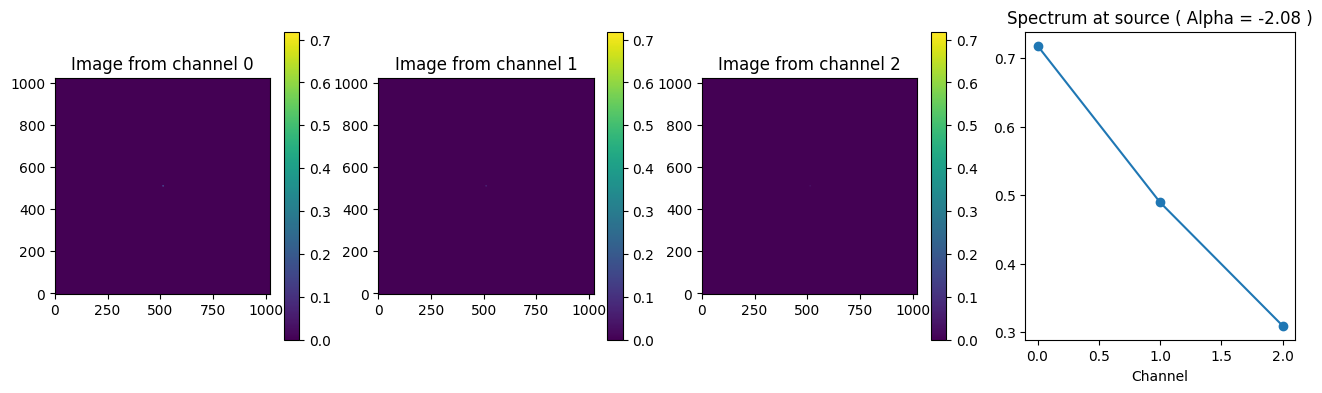

In [ ]:
dispImage('try_cube_standard.image', withspec=True,specloc='mid')

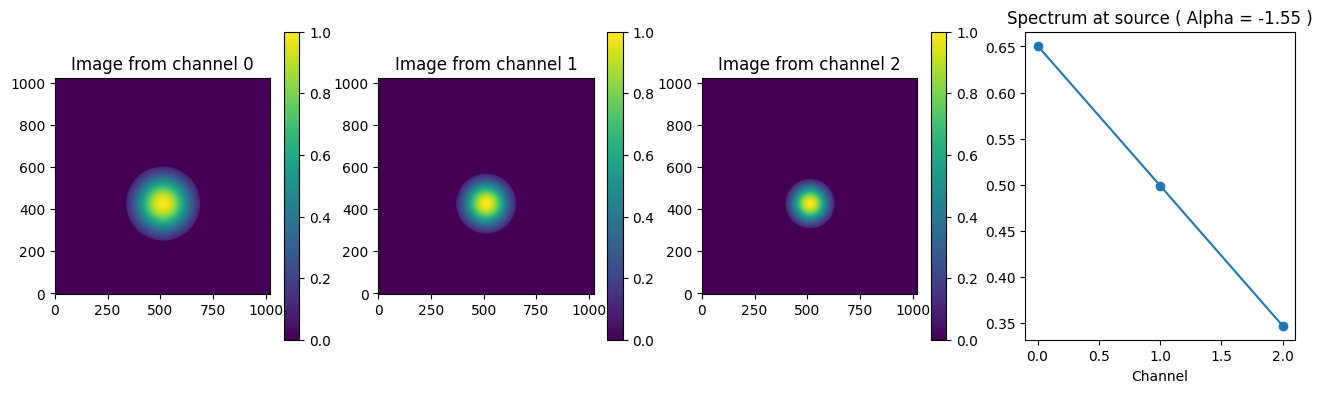

In [ ]:
dispImage('try_cube_standard.pb',withspec=True,specloc='mid')

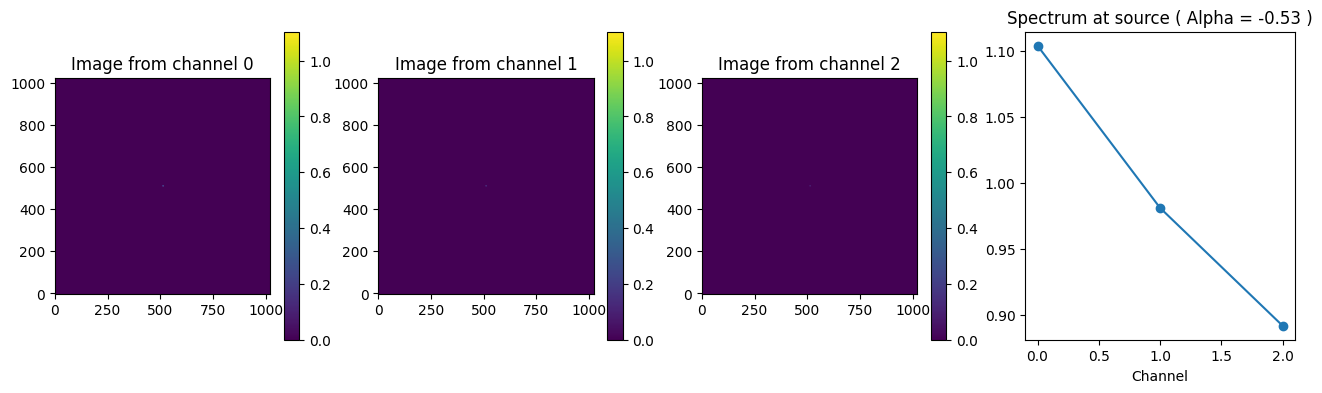

In [ ]:
dispImage('try_cube_standard.image.pbcor',withspec=True,specloc='mid')

_Results_ : The PB-corrected cube shows a sky spectral index of -0.53 which is close to the truth value of -0.5.  


#### Mosaic Gridder

The AProjection algorithm is applied (with assumptions of azimuthal symmetry of PBs and no squint correction). The primary beam model for the VLA is derived from Perley 2016. 

In [ ]:
imagename = 'try_cube_mosaic'
os.system('rm -rf ' + imagename + '.*')
casalog.setlogfile(imagename + '.log')

tclean(vis='wbmos.ms',
       field=fields,
       phasecenter = 'J2000 19h59m28.523 +40d54m01.152',
       imagename=imagename,
       imsize=1024,
       cell='10.0arcsec',
       specmode='cube',
       gridder='mosaic',
       deconvolver='hogbom',
       pblimit=-0.1,
       niter=100,
       pbcor=True);

In [ ]:
printlogs('try_cube_mosaic')



------ Run Major Cycle 1 -------------------------------------
------ Run Major Cycle 1 -------------------------------------
------ Run Minor Cycle Iterations  ---------------------------------------------
[try_cube_mosaic:C0] iters=0->16 [16], model=0->0.584434, peakres=0.717362->0.132929, Reached cyclethreshold.
[try_cube_mosaic:C1] iters=16->28 [12], model=0->0.351275, peakres=0.489534->0.138259, Reached cyclethreshold.
[try_cube_mosaic:C2] iters=28->36 [8], model=0->0.177446, peakres=0.311564->0.134118, Reached cyclethreshold.
[try_cube_mosaic] Total model flux (over all planes) : 1.11315     Peak Residual (over all planes) : 0.138259 in C1:P0
------ Run Major Cycle 2 -------------------------------------
------ Run Major Cycle 2 -------------------------------------
------ Run Minor Cycle Iterations  ---------------------------------------------
[try_cube_mosaic:C0] iters=0->17 [17], model=0.584434->0.703277, peakres=0.141137->0.02684, Reached cyclethreshold.
[try_cube_mosaic:C

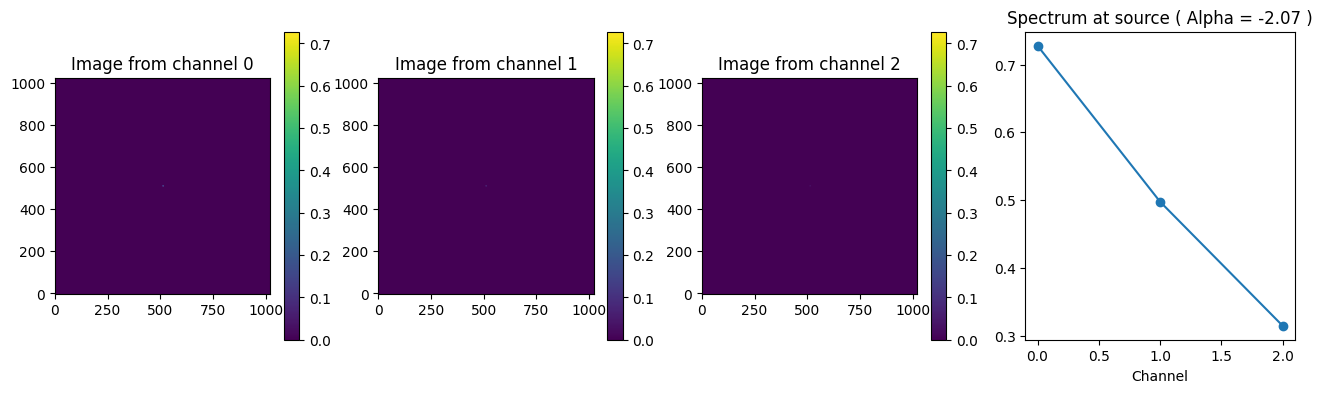

In [ ]:
dispImage('try_cube_mosaic.image', withspec=True,specloc='mid')

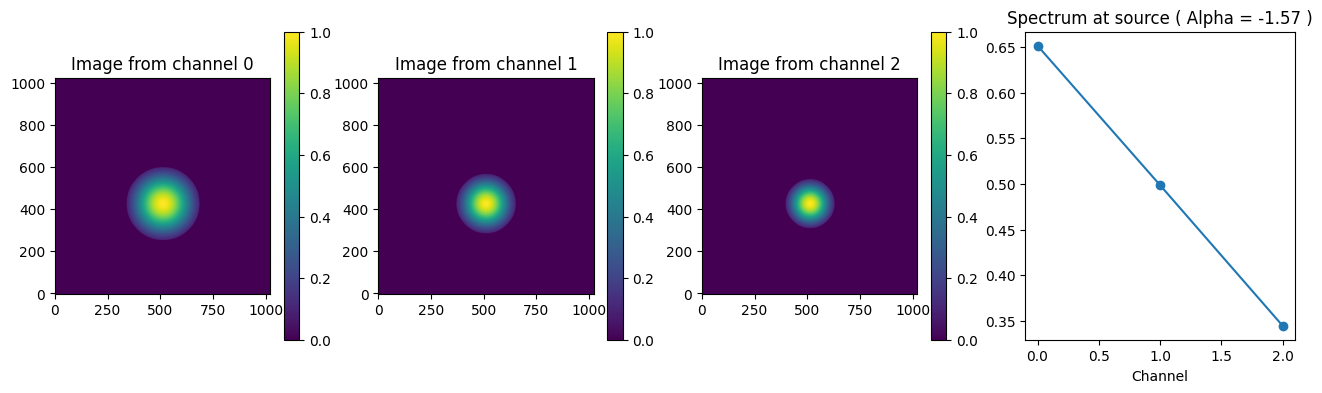

In [ ]:
dispImage('try_cube_mosaic.pb',withspec=True,specloc='mid')

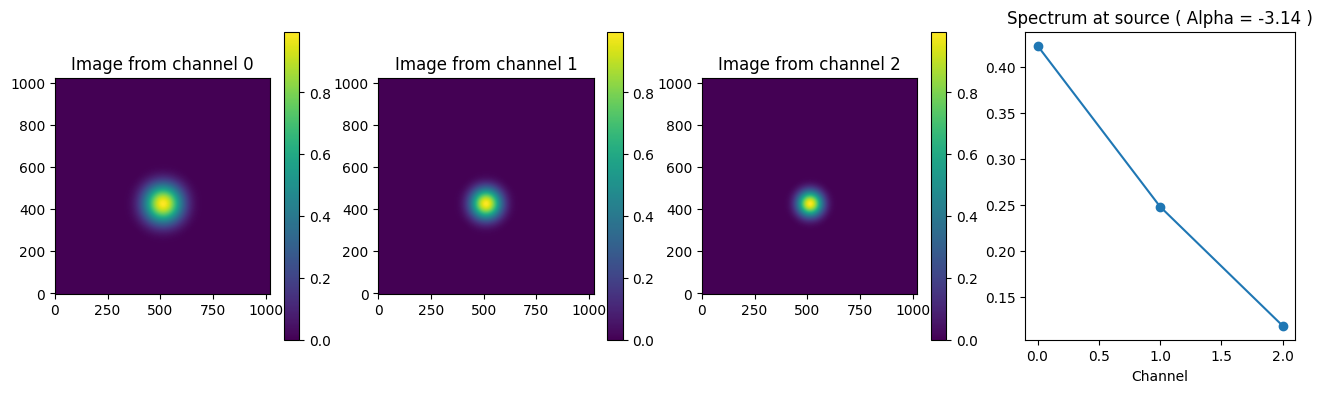

In [ ]:
dispImage('try_cube_mosaic.weight',withspec=True,specloc='mid')
## This shows twice the PB spectral index, as expected.

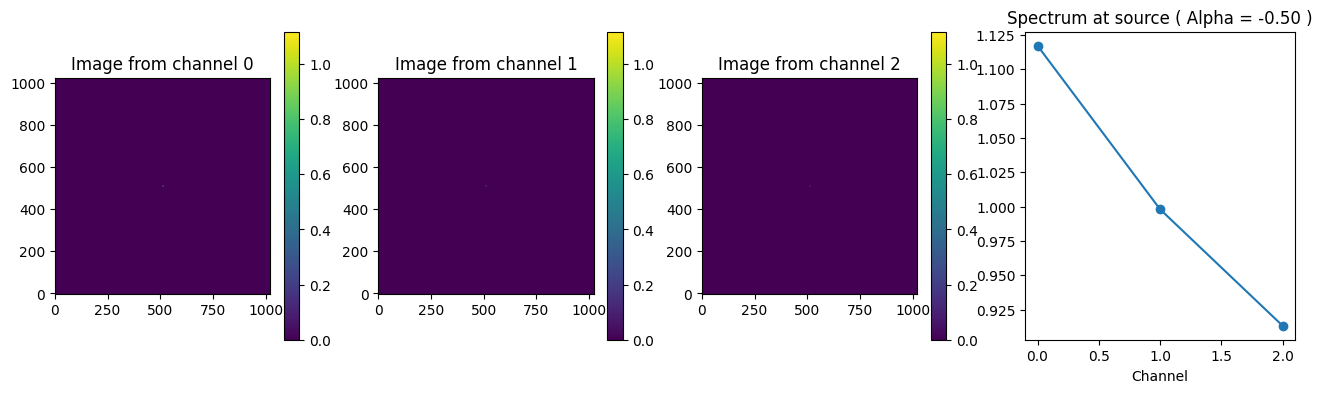

In [ ]:
dispImage('try_cube_mosaic.image.pbcor',withspec=True,specloc='mid')

_Results_ : With the more accurate calculation of the PB model and its application as part of the measurement equation, the sky spectral index is -0.5 (same as the truth value). This simulation was created with the 'mosaic' gridder, and so this serves as a basic consistency check as well.


### Continuum Imaging Option 1 (specmode='mvc')

#### Standard (or WProject) gridder (with specmode='mvc' and deconvolver='mtmfs')
MTMFS imaging with the standard (or wproject) gridder, with **wideband PB correction applied between cube major cycles and mtmfs minor cycles**. This mode is triggered by the specmode='mvc' parameter in tclean (new from CASA 6.6.4 onwards), and eliminates the need for a separate widebandpbcor task call at the end of multi-term deconvolution. The acronym 'mvc' stands for 'multi-term via cube'.

With this algorithm, the reconstructed multi-term model (and restored) images represent the product of the sky and the PB for Stokes I, but with spectral index already corrected for the wideband primary beam.

In [ ]:
imagename = 'try_mvc_standard'
os.system('rm -rf ' + imagename + '.*')
casalog.setlogfile(imagename + '.log')

tclean(vis='wbmos.ms',
       field=fields,
       phasecenter = 'J2000 19h59m28.523 +40d54m01.152',
       imagename=imagename,
       imsize=1024,
       cell='10.0arcsec',
       specmode='mvc',
       gridder='standard',
       deconvolver='mtmfs',
       nterms=2,
       reffreq='1.5GHz',
       nchan=3,
       pblimit=-0.1,
       niter=100,
       pbcor=True);



In [ ]:
printlogs('try_mvc_standard','WARN')

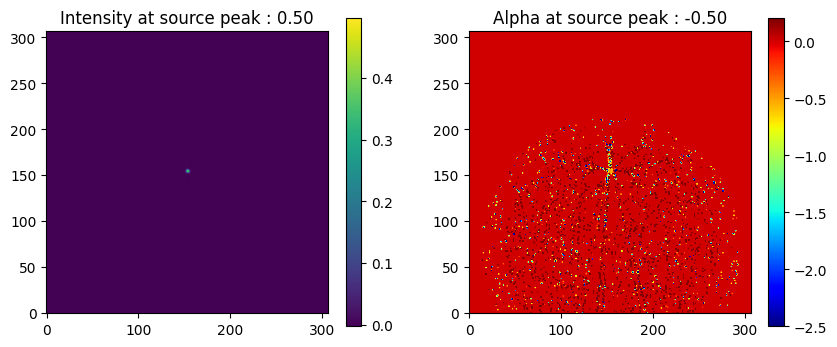

In [ ]:
dispImageAlpha(imname='try_mvc_standard.image.tt0', alname='try_mvc_standard.alpha')

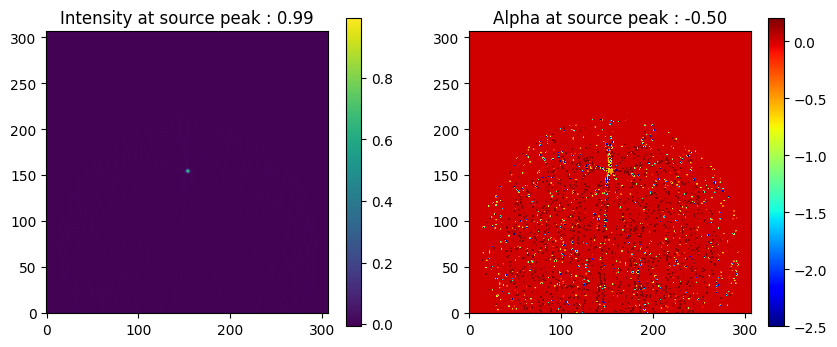

In [ ]:
dispImageAlpha(imname='try_mvc_standard.image.tt0.pbcor', alname='try_mvc_standard.alpha')
## Note the image naming convention for .alpha. There is no need for additional pbcorrection.

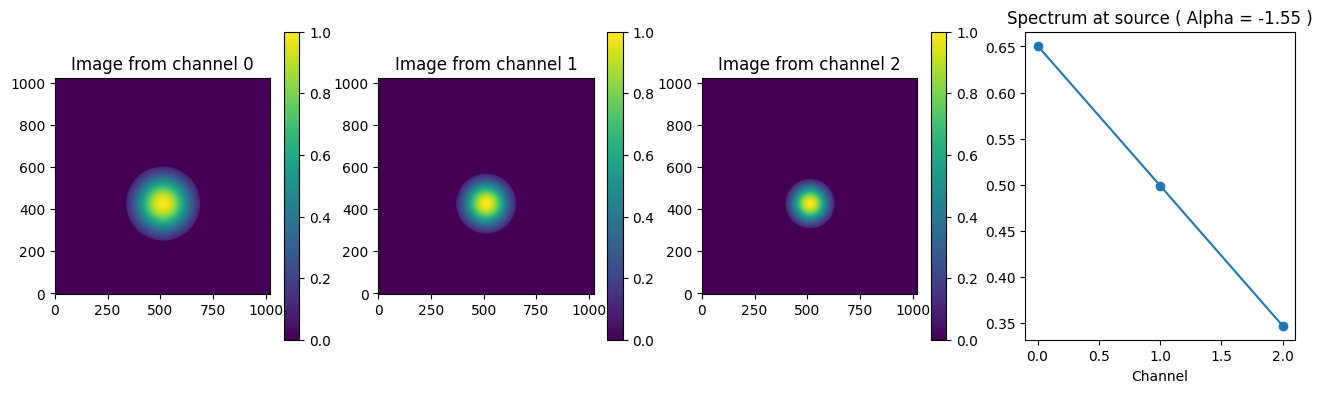

In [ ]:
dispImage('try_mvc_standard.pb',withspec=True,specloc='mid')

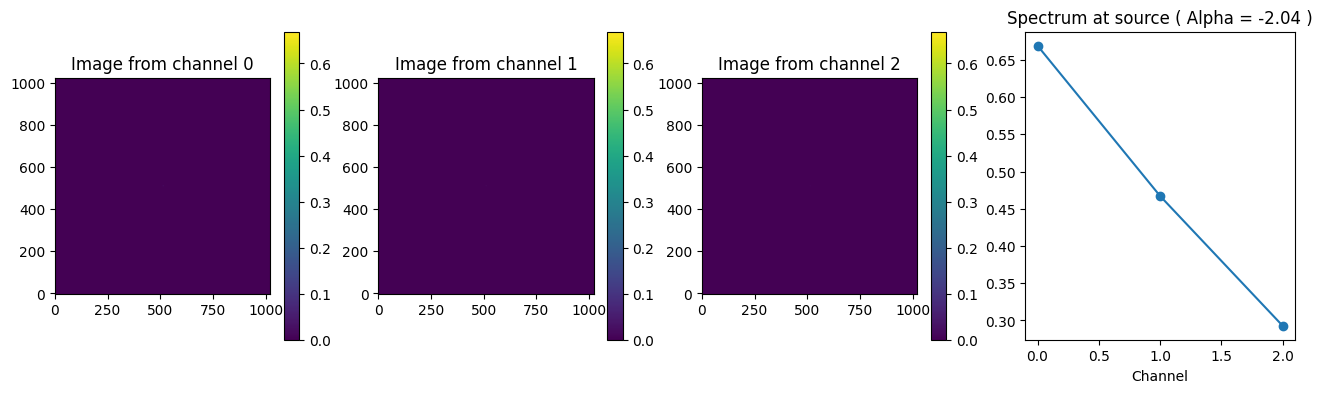

In [ ]:
dispImage('try_mvc_standard.model',withspec=True,specloc='mid')


_Results_ : The pb-corrected intensity is at 0.99 (true=1.0) and spectral index is -0.5 (true=-0.5). 

#### Mosaic gridder (with specmode='mvc' and deconvolver='mtmfs')

Similar to the standard gridder, the reconstructed multi-term model (and restored) images represent the product of the sky and the PB for Stokes I, but with spectral index already corrected for the wideband primary beam.


In [ ]:
imagename = 'try_mvc_mosaic'
os.system('rm -rf ' + imagename + '.*')
casalog.setlogfile(imagename + '.log')

tclean(vis='wbmos.ms',
       field=fields,
       phasecenter = 'J2000 19h59m28.523 +40d54m01.152',
       imagename=imagename,
       imsize=1024,
       cell='10.0arcsec',
       specmode='mvc',
       gridder='mosaic',
       deconvolver='mtmfs',
       nterms=2,
       reffreq='1.5GHz',
       nchan=3,
       pblimit=0.1,
       niter=100,
       pbcor=True);



In [ ]:
printlogs('try_mvc_mosaic','WARN')

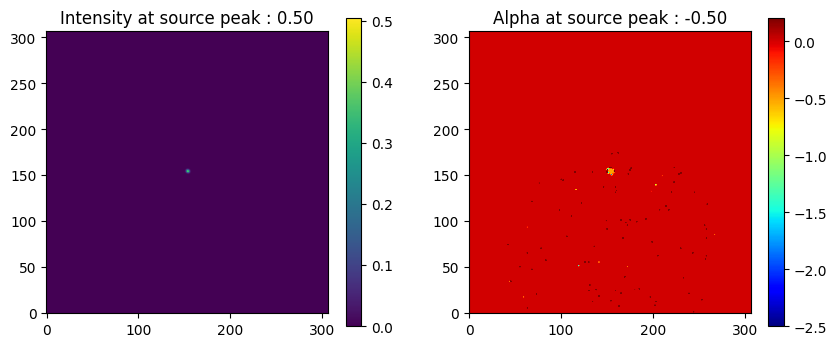

In [ ]:
dispImageAlpha(imname='try_mvc_mosaic.image.tt0', alname='try_mvc_mosaic.alpha')

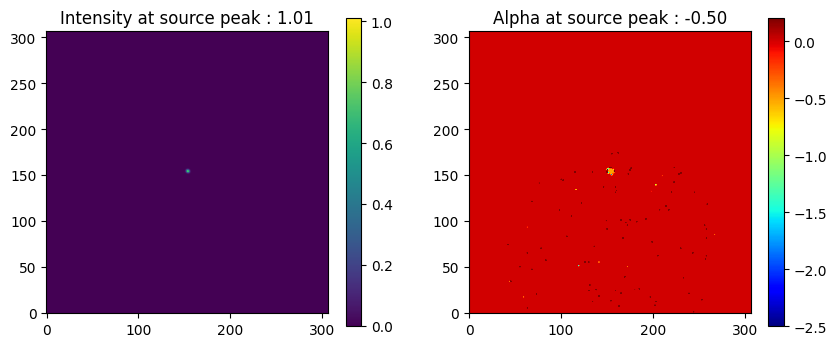

In [ ]:
dispImageAlpha(imname='try_mvc_mosaic.image.tt0.pbcor', alname='try_mvc_mosaic.alpha')
## Note the naming convention, where the .alpha image does not need further pb correction.

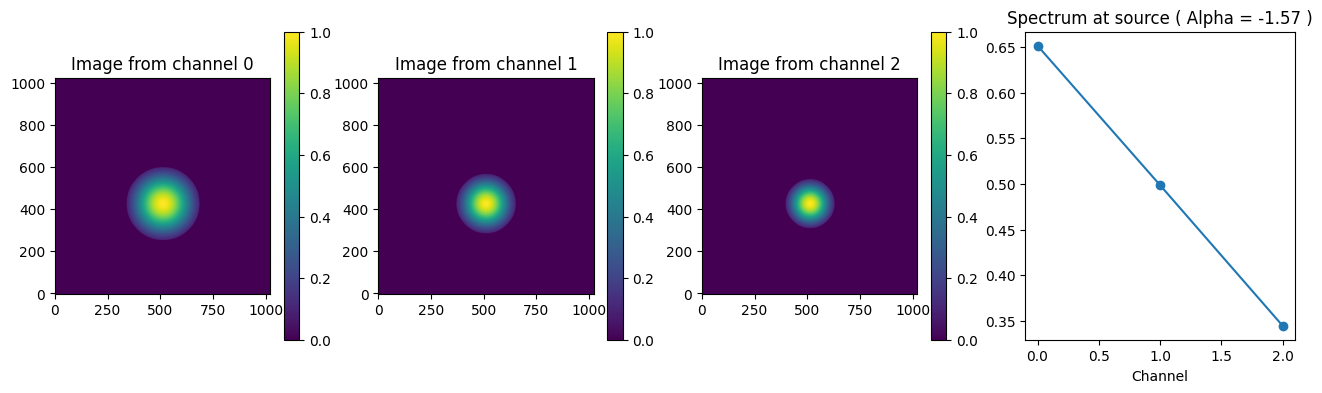

In [ ]:
dispImage('try_mvc_mosaic.pb',withspec=True,specloc='mid')


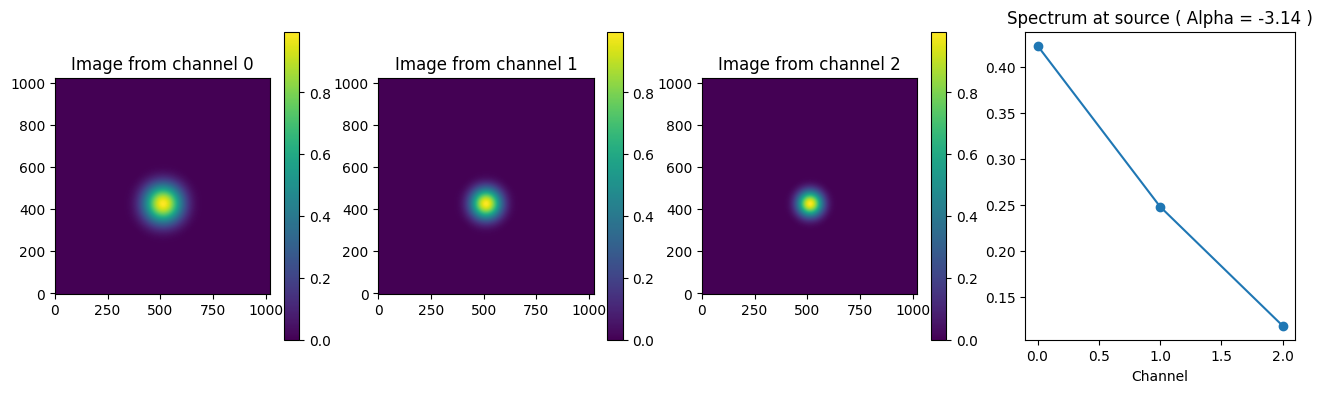

In [ ]:
dispImage('try_mvc_mosaic.weight',withspec=True,specloc='mid')


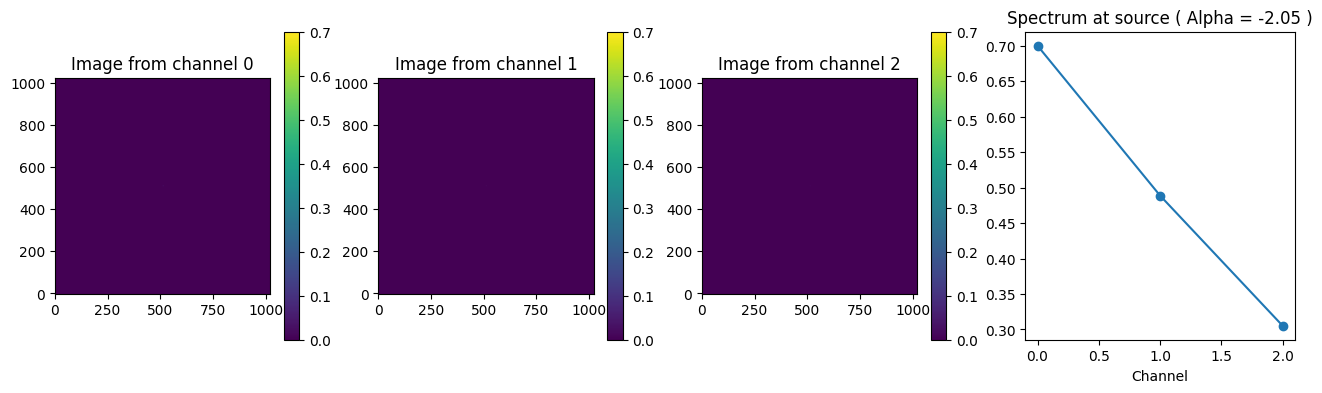

In [ ]:
dispImage('try_mvc_mosaic.model',withspec=True,specloc='mid')


_Results_ : The intensity is at 1.01 (truth=1.0) and spectral index is -0.5 (ideal=-0.5) 

### Continuum Imaging Option 2 (specmode='mfs')

#### Standard (or WProject) gridder (with specmode='mfs' and deconvolver='mtmfs')
MTMFS imaging with the standard (or wproject) gridder, with **wideband PB correction required as a separate step (task_widebandpbcor) at the end of tclean**. This usage mode is expected to be deprecated after CASA 6.6.5, because it is not as numerically accurate as option 1 above (via specmode='mvc').

Without wideband PB correction, the reconstructed multi-term model (and restored) images represent the product of the sky and the PB for Stokes I, and the spectral index represents that of the PB and the sky (-0.5 - 1.5 = -2.0)

In [ ]:
imagename = 'try_mtmfs_standard'
os.system('rm -rf ' + imagename + '.*')
casalog.setlogfile(imagename + '.log')

tclean(vis='wbmos.ms',
       field='0',
       phasecenter = 'J2000 19h59m28.523 +40d54m01.152',
       imagename=imagename,
       imsize=1024,
       cell='10.0arcsec',
       specmode='mfs',
       gridder='standard',
       deconvolver='mtmfs',
       nterms=2,
       reffreq='1.5GHz',
       pblimit=-0.1,
       niter=100,
       pbcor=True)

widebandpbcor(vis='wbmos.ms',
              imagename=imagename,
              field='0',
              nterms=2,
              reffreq='1.5GHz',
              pbmin=0.1,
              spwlist=[0,1,2],
              chanlist=[0,0,0],
              weightlist=[1.0,1.0,1.0])

2024-07-03 15:24:35	WARN	tclean::task_tclean::casa	For specmode='mfs' and deconvolver='mtmfs', the option of pbcor=True divides each restored Taylor coefficient image by the pb.tt0 image. This correction ignores the frequency-dependence of the primary beam and does not correct for PB spectral index. It is scientifically valid only for small fractional bandwidths. For more accurate wideband primary beam correction (if needed), please use one of the following options : (1) specmode='mvc' with gridder='standard' or 'mosaic' with pbcor=True,  (2) conjbeams=True and wbawp=True with gridder='awproject' and pbcor=True.
2024-07-03 15:24:56	WARN	widebandpbcor::::casa	widebandpbcor is a temporary task, meant for use until a widebandpbcor option is enabled from within the tclean task.


In [ ]:
printlogs('try_mtmfs_standard','WARN')

2024-07-03 15:24:35	WARN	tclean::task_tclean::casa	For specmode='mfs' and deconvolver='mtmfs', the option of pbcor=True divides each restored Taylor coefficient image by the pb.tt0 image. This correction ignores the frequency-dependence of the primary beam and does not correct for PB spectral index. It is scientifically valid only for small fractional bandwidths. For more accurate wideband primary beam correction (if needed), please use one of the following options : (1) specmode='mvc' with gridder='standard' or 'mosaic' with pbcor=True,  (2) conjbeams=True and wbawp=True with gridder='awproject' and pbcor=True.

2024-07-03 15:24:56	WARN	widebandpbcor::::casa	widebandpbcor is a temporary task, meant for use until a widebandpbcor option is enabled from within the tclean task.



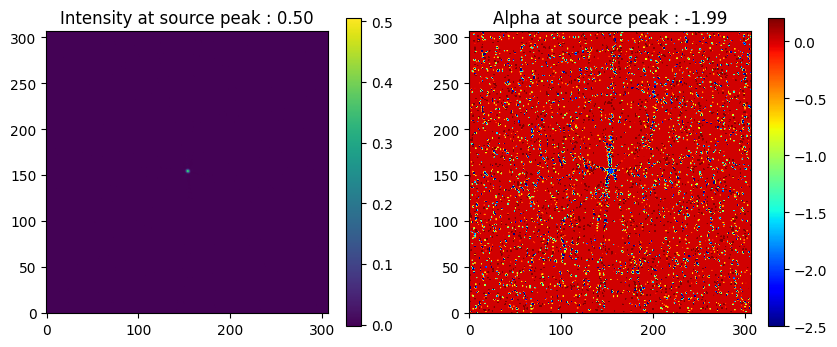

In [ ]:
dispImageAlpha(imname='try_mtmfs_standard.image.tt0', alname='try_mtmfs_standard.alpha')

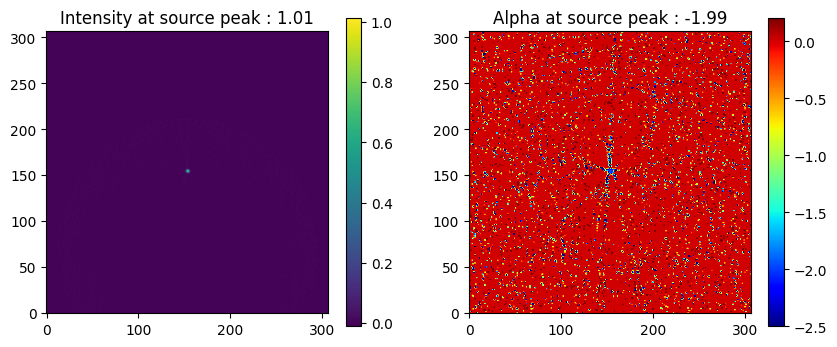

In [ ]:
dispImageAlpha(imname='try_mtmfs_standard.image.tt0.pbcor', alname='try_mtmfs_standard.alpha')

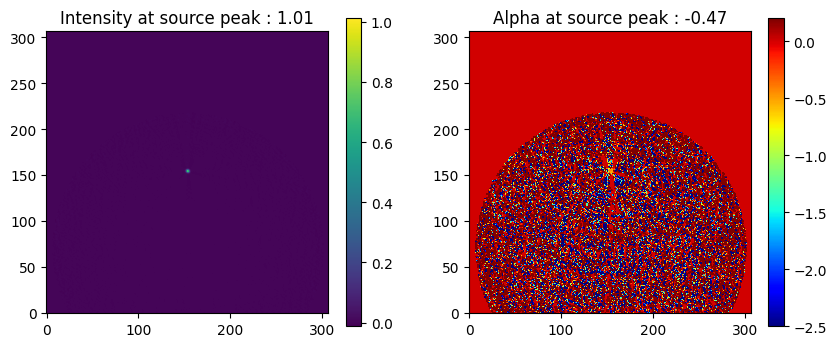

In [ ]:
dispImageAlpha(imname='try_mtmfs_standard.pbcor.image.tt0', alname='try_mtmfs_standard.pbcor.image.alpha')
## Note the naming convention difference between tclean and task_widebandpbcor for the output pb-corrected images.
## These inconsistencies will be avoided by using specmode='mvc' (i.e. Option 1 above) for wideband PB correction.

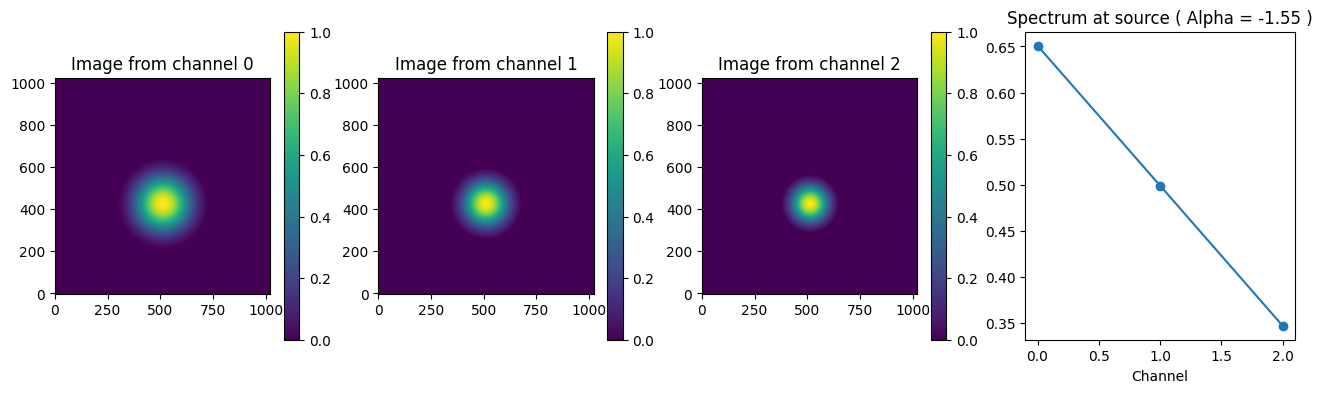

In [ ]:
dispImage('try_mtmfs_standard.pbcor.workdirectory/try_mtmfs_standard.pb.cube',withspec=True,specloc='mid')
## This is the wideband PB model generated by the widebandpbcor task.

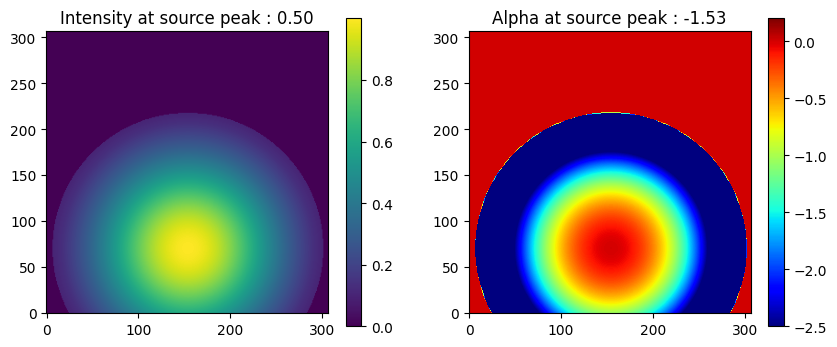

In [ ]:
dispImageAlpha(imname='try_mtmfs_standard.pbcor.workdirectory/try_mtmfs_standard.pb.tt0', alname='try_mtmfs_standard.pbcor.workdirectory/try_mtmfs_standard.pb.alpha')
## This is the PB intensity and spectral index derived by task_widebandpbcor from the above cube,
## and used to correct the output of tclean.

_Results_ : The post-deconvolution correction is (in this example) not as accurate as the per plane correction prior to mtmfs deconvolution. The PB-corrected intensity is 1.01 but the spectral index is -0.47 (ideal = -0.5). 

__Note : The 'mosaic' and 'awproject' gridders currently do not give accurate wideband PB-correction with specmode='mfs' and deconvolver='mtmfs' due to inconsistencies in the implementation of the 'conjbeams' parameter. Alternatives will be published in a later release.__ 


### Imaging With Custom Primary Beams

This section shows how to use a custom primary beam model with the above options. As an example, a GMRT beam model is constructed via a "VP-table" using code from a [GMRT widebandpbcor task](https://github.com/ruta-k/uGMRTprimarybeam), and used with the above dataset.

With specmode='mvc', and the use of an external vptable, we can eliminate the need for using task_widebandpbcor.

Note : For the following contrived example, the PB corrected values will be incorrect because the dataset used in
this example is simulated with VLA beams but we are using GMRT beams to correct it.  But, this example illustrates that the externally supplied beam model is being used.


In [ ]:
## In this example, we "fake" the telescope name to be EVLA, so that tclean uses these
## externally supplied beams for the simulated dataset that has observatory_name=EVLA.

def make_vp_table(vptab='gmrt_beams.vp',band=5):

    os.system('rm -rf '+vptab)
    vp.reset()

    if band==2: ## (1.25<freq<2.5): # Band 2
        print("Primary beam parameters are not yet available for this band.")
        #vp.setpbpoly(telescope ='GMRT',  usesymmetricbeam=True, coeff=np.array([1, -2.9061046e-3, 33.13585706e-7,  -17.23287036e-10,   3.45117443e-13 ])) # frequencywise polynomial to be given here
    elif band==3: ##(2.5<freq<5.0):# Band 3
        vp.setpbpoly(telescope ='EVLA',  usesymmetricbeam=True, coeff=np.array([1, -2.939e-3, 33.312e-7, -16.659e-10,   3.066e-13])) # frequencywise polynomial to be given here
    elif band==4: ## (5.5<freq<9.5): # Band 4
        vp.setpbpoly(telescope ='EVLA',  usesymmetricbeam=True, coeff=np.array([1, -3.190e-3, 38.642e-7, -20.471e-10,   3.964e-13])) # frequencywise polynomial to be given here
    elif band==5: ## (10.5<freq<15): # L-band or Band 5
        vp.setpbpoly(telescope ='EVLA',  usesymmetricbeam=True, coeff=np.array([1, -2.608e-3, 27.357e-7, -13.091e-10, 2.368e-13])) # frequencywise polynomial to be given here

    vp.summarizevps()
    vp.saveastable(vptab)

In [ ]:
make_vp_table()

2024-07-03 15:25:44	WARN	PBMath::pbMathInterfaceForCommonPB	ATCA_L3 not yet implemented defaulting to L2 version


#### Standard Gridder (with specmode='mvc' and an external vptable)

This example replicates the first example in this notebook, but with PBs of different sizes. The deviation of the results from the first example are evidence of the use of the user-supplied primary beam models, with the spectral index model and correction being consistent with a larger dish (or smaller f-o-v). 

In [ ]:
imagename = 'try_mvc_standard_otherpb'
os.system('rm -rf ' + imagename + '.*')
casalog.setlogfile(imagename + '.log')

tclean(vis='wbmos.ms',
       field=fields,
       phasecenter = 'J2000 19h59m28.523 +40d54m01.152',
       imagename=imagename,
       imsize=1024,
       cell='10.0arcsec',
       specmode='mvc',
       gridder='standard',
       vptable='gmrt_beams.vp',      ### externally supplied primary beams.
       deconvolver='mtmfs',
       nterms=2,
       reffreq='1.5GHz',
       nchan=3,
       pblimit=-0.1,
       niter=100,
       pbcor=True);



In [ ]:
printlogs('try_mvc_standard_otherpb','WARN')

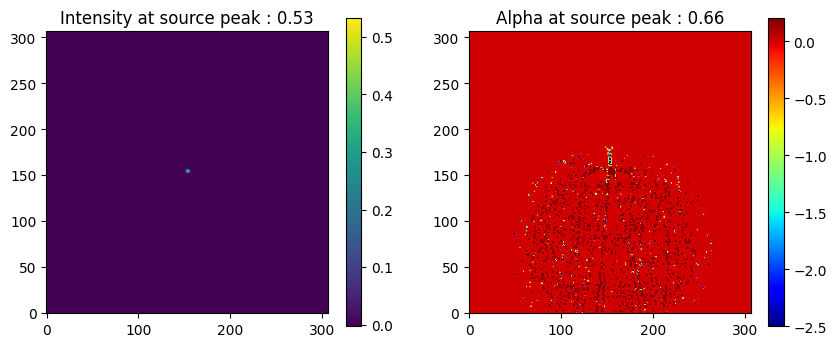

In [ ]:
dispImageAlpha(imname='try_mvc_standard_otherpb.image.tt0', alname='try_mvc_standard_otherpb.alpha')

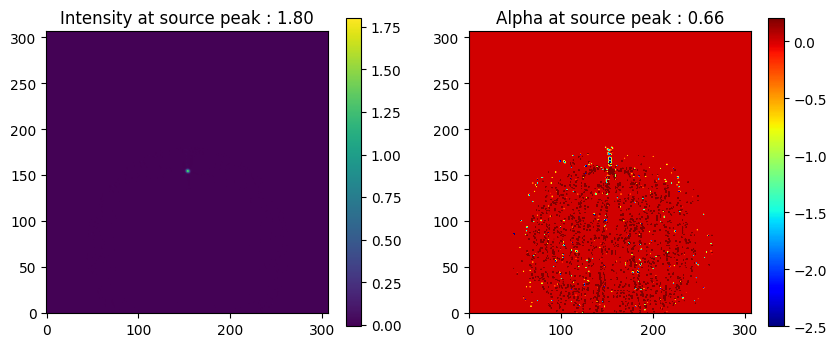

In [ ]:
dispImageAlpha(imname='try_mvc_standard_otherpb.image.tt0.pbcor', alname='try_mvc_standard_otherpb.alpha')
## Note the image naming convention for .alpha. There is no need for additional pbcorrection.

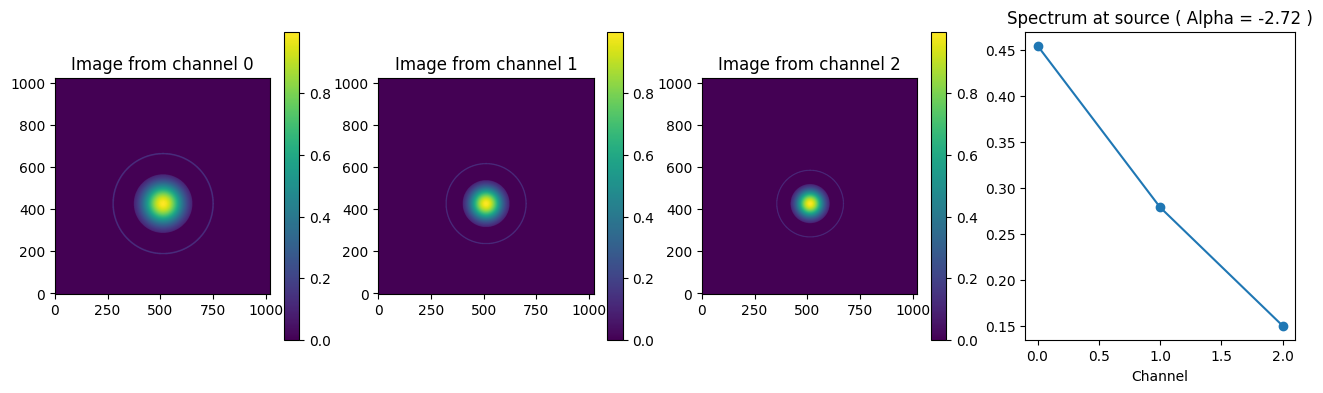

In [ ]:
dispImage('try_mvc_standard_otherpb.pb',withspec=True,specloc='mid')
## The PB spectral index is clearly different from the VLA.
## With the larger GMRT dish at L-band, the PB is smaller, and the source sees a stronger PB spectral index.

_Results_ : We see over-correction of the spectral index (-2.0 + 2.7 = +0.7) and intensity, consistent with the steeper spectral index and lower PB gain of a larger dish. Note - this is intentionally incorrect (a GMRT beam used to correct VLA data), and included here only to illustrate the usage mode of supplying external PB models to tclean(specmode='mvc').


#### Mosaic Gridder (with specmode='mvc' and an external vptable)

In [ ]:
imagename = 'try_mvc_mosaic_otherpb'
os.system('rm -rf ' + imagename + '.*')
casalog.setlogfile(imagename + '.log')

tclean(vis='wbmos.ms',
       field=fields,
       phasecenter = 'J2000 19h59m28.523 +40d54m01.152',
       imagename=imagename,
       imsize=1024,
       cell='10.0arcsec',
       specmode='mvc',
       gridder='mosaic',
       vptable='gmrt_beams.vp',        ## externally supplied primary beams
       deconvolver='mtmfs',
       nterms=2,
       reffreq='1.5GHz',
       nchan=3,
       pblimit=-0.1,
       niter=100,
       pbcor=True);



In [ ]:
printlogs('try_mvc_mosaic_otherpb','WARN')

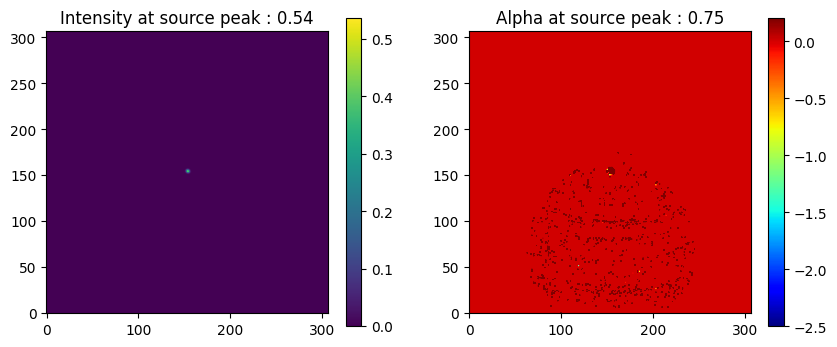

In [ ]:
dispImageAlpha(imname='try_mvc_mosaic_otherpb.image.tt0', alname='try_mvc_mosaic_otherpb.alpha')

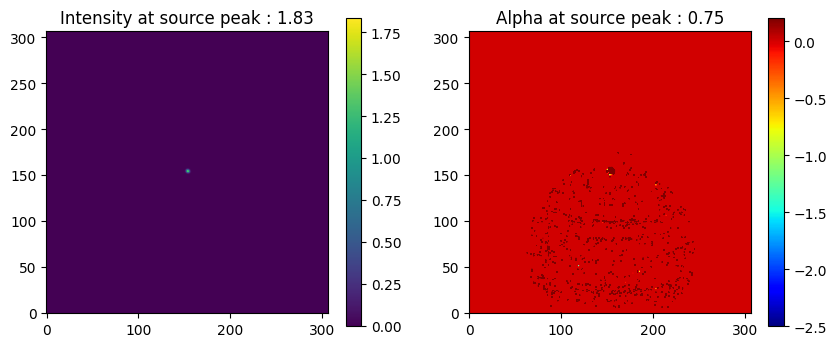

In [ ]:
dispImageAlpha(imname='try_mvc_mosaic_otherpb.image.tt0.pbcor', alname='try_mvc_mosaic_otherpb.alpha')
## Note the image naming convention for .alpha. There is no need for additional pbcorrection.

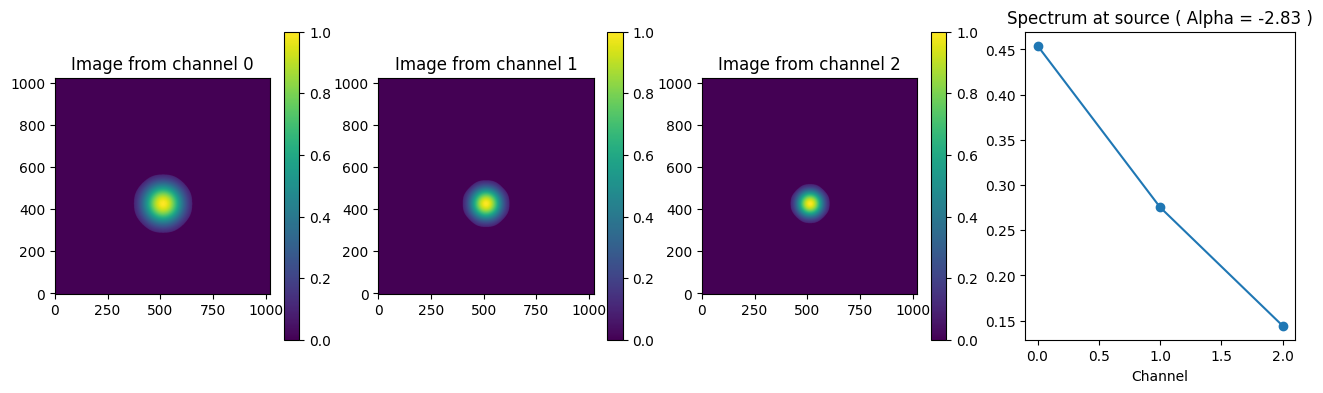

In [ ]:
dispImage('try_mvc_mosaic_otherpb.pb',withspec=True,specloc='mid')

_Results_ : Similar to the above 'standard' gridder example. 